In [1]:
# Installing required Libraries
%pip install torch torchvision matplotlib seaborn opencv-python-headless scikit-learn streamlit

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\hasri\appdata\local\programs\python\python312\lib\site-packages\gdown-5.2.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\hasri\appdata\local\programs\python\python312\lib\site-packages\hippo_vnet-0.0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importing required Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import streamlit as st
from PIL import Image

c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Dataset and model save paths
dataset_path = "Dataset"
model_save_path = "saved_models"
os.makedirs(model_save_path, exist_ok=True)

# Class names
class_names = ["Mild", "Moderate", "Normal", "Severe"]

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to train
model_names = [
    "mobilenetv3_small_100",
    "shufflenet_v2_x0_5",
    "shufflenet_v2_x1_0",
    "squeezenet1_0",
    "squeezenet1_1",
    "googlenet",
]

In [4]:
# Define transforms for data augmentation and normalization
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "valid_test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

# Load dataset
dataset = datasets.ImageFolder(dataset_path, transform=data_transforms["train"])

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [train_size, valid_size, test_size]
)

# Apply validation/test transformations to validation and test datasets
valid_dataset.dataset.transform = data_transforms["valid_test"]
test_dataset.dataset.transform = data_transforms["valid_test"]

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6998693..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.2489083].


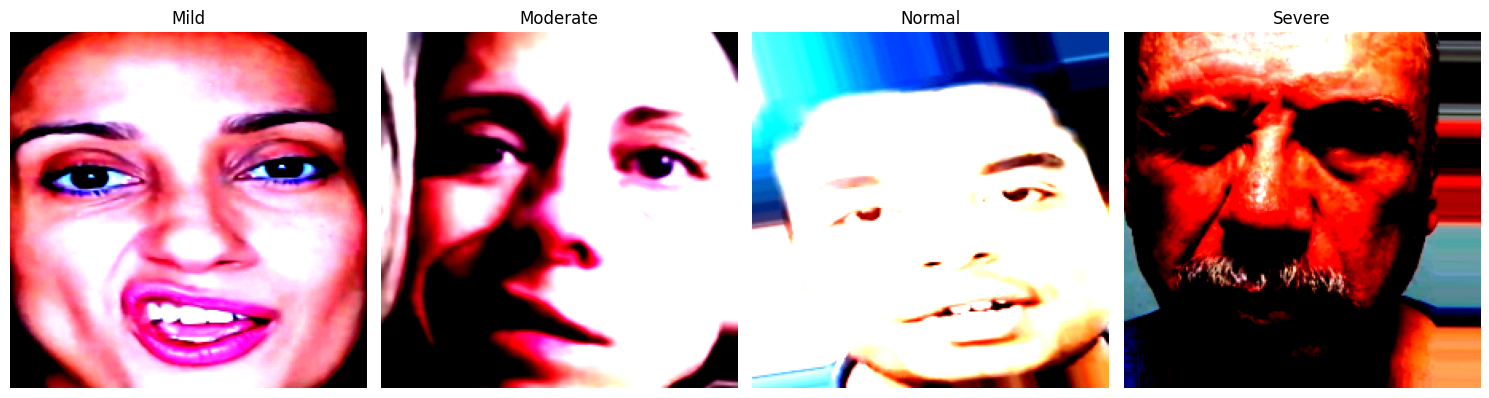

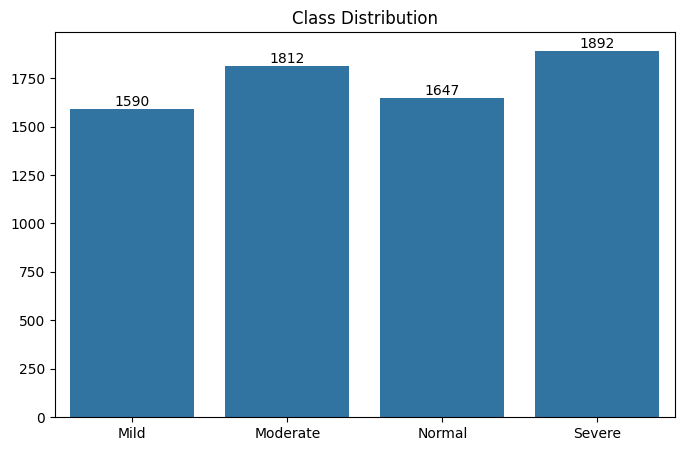

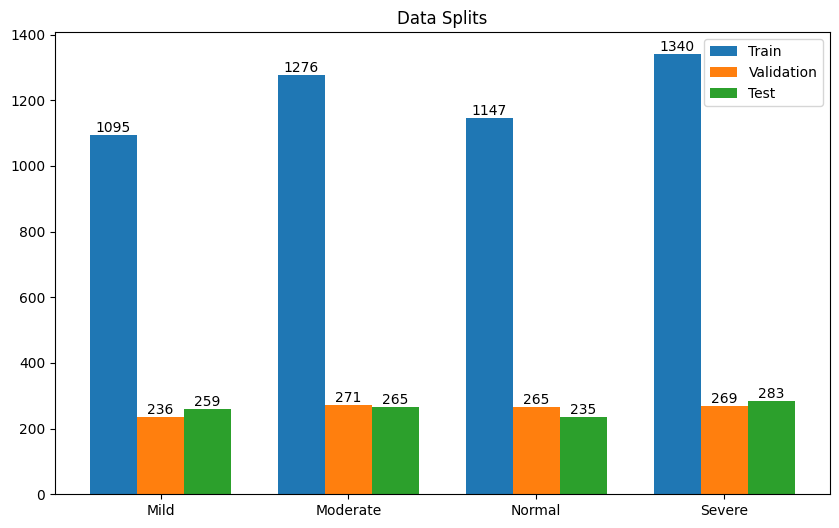

In [5]:
# Plot sample images from each class
def plot_sample_images(dataset, class_names):
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))
    for i, class_name in enumerate(class_names):
        for img, label in dataset:
            if label == i:
                axes[i].imshow(img.permute(1, 2, 0).numpy())
                axes[i].set_title(class_name)
                axes[i].axis("off")
                break
    plt.tight_layout()
    plt.show()

# Plot bar graph of class distribution
def plot_class_distribution(dataset, class_names):
    class_counts = [0] * len(class_names)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_names, y=class_counts)
    plt.title("Class Distribution")
    for i, count in enumerate(class_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

# Plot bar graph of data splits
def plot_data_splits(train_dataset, valid_dataset, test_dataset, class_names):
    splits = {"Train": train_dataset, "Validation": valid_dataset, "Test": test_dataset}
    split_counts = {split: [0] * len(class_names) for split in splits}

    for split_name, dataset in splits.items():
        for _, label in dataset:
            split_counts[split_name][label] += 1

    x = np.arange(len(class_names))
    width = 0.25

    plt.figure(figsize=(10, 6))
    for i, (split_name, counts) in enumerate(split_counts.items()):
        plt.bar(x + i * width, counts, width, label=split_name)

    plt.xticks(x + width, class_names)
    plt.title("Data Splits")
    plt.legend()
    for i, (split_name, counts) in enumerate(split_counts.items()):
        for j, count in enumerate(counts):
            plt.text(j + i * width, count, str(count), ha='center', va='bottom')
    plt.show()

# Call the EDA functions
plot_sample_images(dataset, class_names)
plot_class_distribution(dataset, class_names)
plot_data_splits(train_dataset, valid_dataset, test_dataset, class_names)

In [16]:
# Load Pretrained models
def get_model(model_name):

    if model_name == "mobilenetv3_small_100":
        model = models.mobilenet_v3_small(weights=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(class_names))
    
    elif model_name == "shufflenet_v2_x0_5":
        model = models.shufflenet_v2_x0_5(weights=True)
        model.fc = nn.Linear(model.fc.in_features, len(class_names))

    elif model_name == "shufflenet_v2_x1_0":
        model = models.shufflenet_v2_x1_0(weights=True)
        model.fc = nn.Linear(model.fc.in_features, len(class_names))
    
    elif model_name == "squeezenet1_0":
        model = models.squeezenet1_0(weights=True)
        model.classifier[1] = nn.Conv2d(512, len(class_names), kernel_size=(1, 1))

    elif model_name == "squeezenet1_1":
        model = models.squeezenet1_1(weights=True)
        model.classifier[1] = nn.Conv2d(512, len(class_names), kernel_size=(1, 1))
    
    elif model_name == "googlenet":
        model = models.googlenet(weights=True)
        model.fc = nn.Linear(model.fc.in_features, len(class_names))

    else:
        raise ValueError(f"Model {model_name} not supported!")

    return model.to(device)


In [17]:
# Training and Validation Function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, model_name):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_predictions = 0.0, 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        train_loss = running_loss / total_samples
        train_accuracy = correct_predictions / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss, correct_predictions = 0.0, 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                correct_predictions += torch.sum(preds == labels).item()
                total_samples += labels.size(0)

        valid_loss = running_loss / total_samples
        valid_accuracy = correct_predictions / total_samples
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(
            f"Epoch [{epoch+1}/{num_epochs}]: "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}"
        )

    # Save the trained model
    torch.save(model.state_dict(), f"{model_save_path}/{model_name}_model.pth")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [18]:
# Learning Curves Funtion
def plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, valid_accuracies, label="Valid Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification report and confusion matrix
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)

    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]: Train Loss: 0.4572, Train Accuracy: 0.8619, Valid Loss: 0.2545, Valid Accuracy: 0.9500
Epoch [2/10]: Train Loss: 0.1024, Train Accuracy: 0.9710, Valid Loss: 0.1163, Valid Accuracy: 0.9750
Epoch [3/10]: Train Loss: 0.0555, Train Accuracy: 0.9833, Valid Loss: 0.0811, Valid Accuracy: 0.9731
Epoch [4/10]: Train Loss: 0.0402, Train Accuracy: 0.9885, Valid Loss: 0.0803, Valid Accuracy: 0.9769
Epoch [5/10]: Train Loss: 0.0308, Train Accuracy: 0.9901, Valid Loss: 0.0591, Valid Accuracy: 0.9760
Epoch [6/10]: Train Loss: 0.0207, Train Accuracy: 0.9932, Valid Loss: 0.0505, Valid Accuracy: 0.9808
Epoch [7/10]: Train Loss: 0.0118, Train Accuracy: 0.9963, Valid Loss: 0.0586, Valid Accuracy: 0.9798
Epoch [8/10]: Train Loss: 0.0118, Train Accuracy: 0.9961, Valid Loss: 0.0880, Valid Accuracy: 0.9769
Epoch [9/10]: Train Loss: 0.0070, Train Accuracy: 0.9984, Valid Loss: 0.0662, Valid Accuracy: 0.9769
Epoch [10/10]: Train Loss: 0.0069, Train Accuracy: 0.9975, Valid Loss: 0.1000, Valid Accura

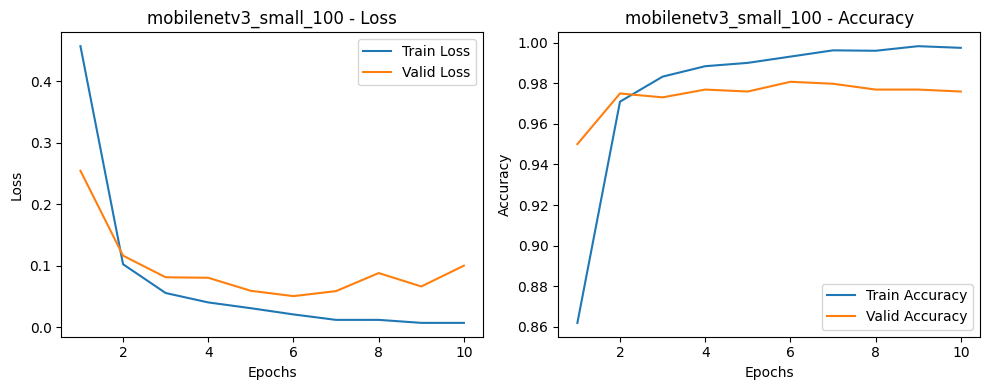


Classification Report:
               precision    recall  f1-score   support

        Mild       0.98      1.00      0.99       259
    Moderate       0.96      0.97      0.96       265
      Normal       1.00      0.97      0.98       235
      Severe       0.97      0.97      0.97       283

    accuracy                           0.98      1042
   macro avg       0.98      0.98      0.98      1042
weighted avg       0.98      0.98      0.98      1042



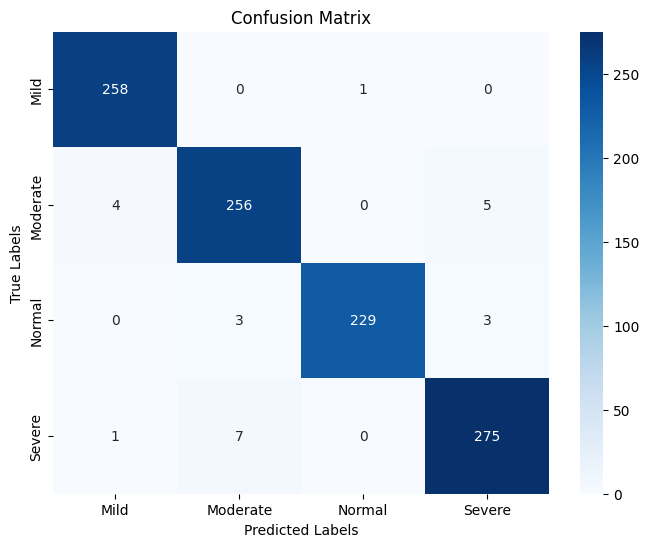

In [20]:
# MobileNetV3_Small Model
# Load the model
model_name = "mobilenetv3_small_100"
model = get_model(model_name)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, model_name
)

# Plot learning curves
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name)

# Evaluate on test set
evaluate_model(model, test_loader)

c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]: Train Loss: 1.2281, Train Accuracy: 0.6741, Valid Loss: 0.8824, Valid Accuracy: 0.8146
Epoch [2/10]: Train Loss: 0.6194, Train Accuracy: 0.8567, Valid Loss: 0.3240, Valid Accuracy: 0.9404
Epoch [3/10]: Train Loss: 0.2574, Train Accuracy: 0.9475, Valid Loss: 0.1503, Valid Accuracy: 0.9664
Epoch [4/10]: Train Loss: 0.1597, Train Accuracy: 0.9611, Valid Loss: 0.1128, Valid Accuracy: 0.9721
Epoch [5/10]: Train Loss: 0.1271, Train Accuracy: 0.9673, Valid Loss: 0.0956, Valid Accuracy: 0.9741
Epoch [6/10]: Train Loss: 0.0965, Train Accuracy: 0.9763, Valid Loss: 0.0933, Valid Accuracy: 0.9721
Epoch [7/10]: Train Loss: 0.0845, Train Accuracy: 0.9798, Valid Loss: 0.0796, Valid Accuracy: 0.9750
Epoch [8/10]: Train Loss: 0.0618, Train Accuracy: 0.9854, Valid Loss: 0.0723, Valid Accuracy: 0.9779
Epoch [9/10]: Train Loss: 0.0561, Train Accuracy: 0.9860, Valid Loss: 0.0804, Valid Accuracy: 0.9741
Epoch [10/10]: Train Loss: 0.0419, Train Accuracy: 0.9895, Valid Loss: 0.0781, Valid Accura

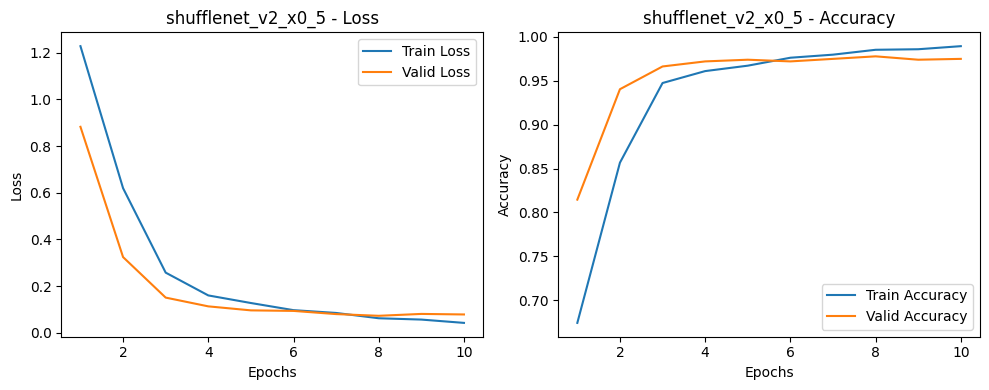


Classification Report:
               precision    recall  f1-score   support

        Mild       0.99      1.00      0.99       259
    Moderate       0.95      0.97      0.96       265
      Normal       1.00      0.99      0.99       235
      Severe       0.97      0.95      0.96       283

    accuracy                           0.98      1042
   macro avg       0.98      0.98      0.98      1042
weighted avg       0.98      0.98      0.98      1042



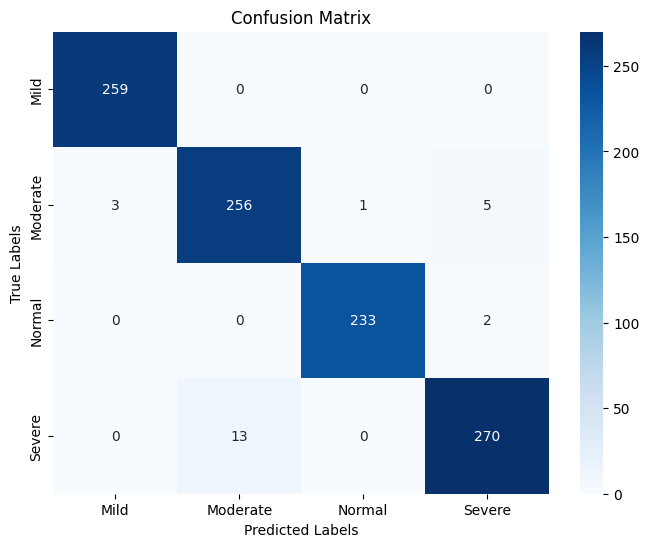

In [21]:
# ShuffleNet_V2_X0_5 Model
# Load the model
model_name = "shufflenet_v2_x0_5"
model = get_model(model_name)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, model_name
)

# Plot learning curves
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name)

# Evaluate on test set
evaluate_model(model, test_loader)

c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]: Train Loss: 1.0947, Train Accuracy: 0.7552, Valid Loss: 0.5058, Valid Accuracy: 0.9356
Epoch [2/10]: Train Loss: 0.3678, Train Accuracy: 0.9539, Valid Loss: 0.1846, Valid Accuracy: 0.9702
Epoch [3/10]: Train Loss: 0.1646, Train Accuracy: 0.9720, Valid Loss: 0.1062, Valid Accuracy: 0.9760
Epoch [4/10]: Train Loss: 0.1100, Train Accuracy: 0.9807, Valid Loss: 0.0826, Valid Accuracy: 0.9760
Epoch [5/10]: Train Loss: 0.0663, Train Accuracy: 0.9893, Valid Loss: 0.0693, Valid Accuracy: 0.9827
Epoch [6/10]: Train Loss: 0.0423, Train Accuracy: 0.9926, Valid Loss: 0.0899, Valid Accuracy: 0.9741
Epoch [7/10]: Train Loss: 0.0320, Train Accuracy: 0.9953, Valid Loss: 0.0740, Valid Accuracy: 0.9769
Epoch [8/10]: Train Loss: 0.0261, Train Accuracy: 0.9965, Valid Loss: 0.0729, Valid Accuracy: 0.9769
Epoch [9/10]: Train Loss: 0.0222, Train Accuracy: 0.9949, Valid Loss: 0.0697, Valid Accuracy: 0.9779
Epoch [10/10]: Train Loss: 0.0235, Train Accuracy: 0.9953, Valid Loss: 0.0834, Valid Accura

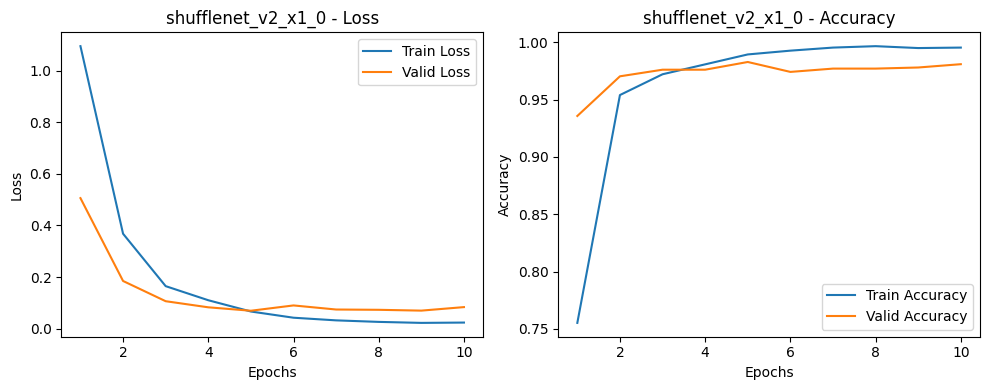


Classification Report:
               precision    recall  f1-score   support

        Mild       0.99      1.00      0.99       259
    Moderate       0.96      0.98      0.97       265
      Normal       1.00      1.00      1.00       235
      Severe       0.99      0.96      0.98       283

    accuracy                           0.99      1042
   macro avg       0.99      0.99      0.99      1042
weighted avg       0.99      0.99      0.99      1042



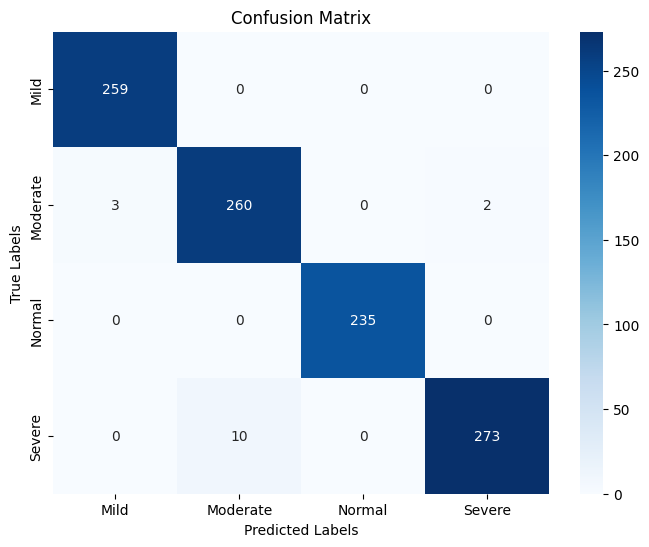

In [22]:
# ShuffleNet_V2_X1_0 Model
# Load the model
model_name = "shufflenet_v2_x1_0"
model = get_model(model_name)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, model_name
)

# Plot learning curves
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name)

# Evaluate on test set
evaluate_model(model, test_loader)

c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\hasri/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 13.5MB/s]


Epoch [1/10]: Train Loss: 0.3988, Train Accuracy: 0.8604, Valid Loss: 0.1658, Valid Accuracy: 0.9558
Epoch [2/10]: Train Loss: 0.1718, Train Accuracy: 0.9471, Valid Loss: 0.1189, Valid Accuracy: 0.9587
Epoch [3/10]: Train Loss: 0.1187, Train Accuracy: 0.9646, Valid Loss: 0.1167, Valid Accuracy: 0.9616
Epoch [4/10]: Train Loss: 0.0925, Train Accuracy: 0.9734, Valid Loss: 0.1083, Valid Accuracy: 0.9702
Epoch [5/10]: Train Loss: 0.0810, Train Accuracy: 0.9755, Valid Loss: 0.1949, Valid Accuracy: 0.9337
Epoch [6/10]: Train Loss: 0.0658, Train Accuracy: 0.9809, Valid Loss: 0.0785, Valid Accuracy: 0.9693
Epoch [7/10]: Train Loss: 0.0607, Train Accuracy: 0.9804, Valid Loss: 0.0735, Valid Accuracy: 0.9712
Epoch [8/10]: Train Loss: 0.0496, Train Accuracy: 0.9837, Valid Loss: 0.1137, Valid Accuracy: 0.9645
Epoch [9/10]: Train Loss: 0.0737, Train Accuracy: 0.9767, Valid Loss: 0.0703, Valid Accuracy: 0.9731
Epoch [10/10]: Train Loss: 0.0388, Train Accuracy: 0.9864, Valid Loss: 0.0559, Valid Accura

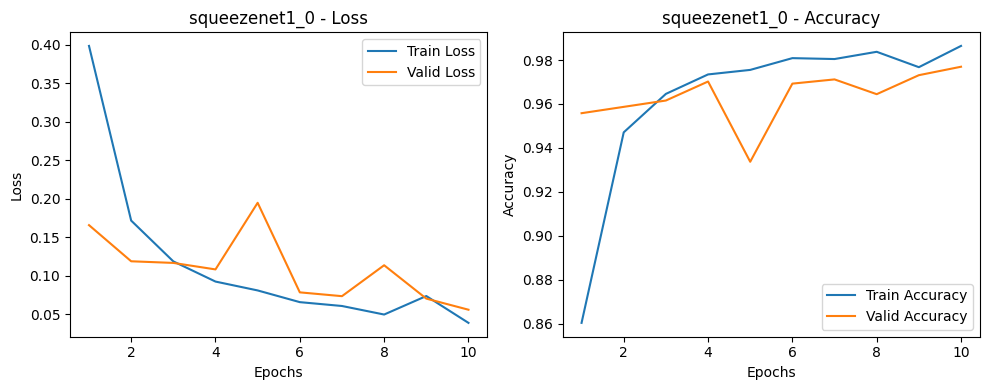


Classification Report:
               precision    recall  f1-score   support

        Mild       0.98      1.00      0.99       259
    Moderate       0.95      0.98      0.96       265
      Normal       1.00      1.00      1.00       235
      Severe       0.99      0.94      0.97       283

    accuracy                           0.98      1042
   macro avg       0.98      0.98      0.98      1042
weighted avg       0.98      0.98      0.98      1042



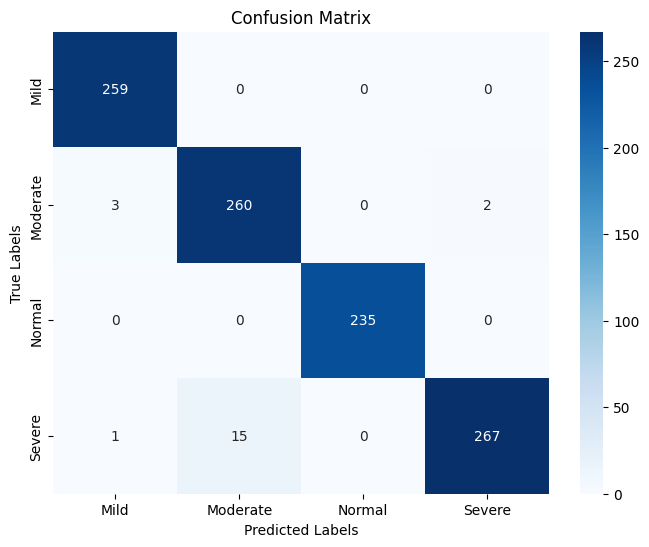

In [23]:
# SqueezeNet1_0 Model
# Load the model
model_name = "squeezenet1_0"
model = get_model(model_name)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, model_name
)

# Plot learning curves
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name)

# Evaluate on test set
evaluate_model(model, test_loader)

c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to C:\Users\hasri/.cache\torch\hub\checkpoints\squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 15.1MB/s]


Epoch [1/10]: Train Loss: 0.5157, Train Accuracy: 0.8059, Valid Loss: 0.2972, Valid Accuracy: 0.9087
Epoch [2/10]: Train Loss: 0.1787, Train Accuracy: 0.9481, Valid Loss: 0.2278, Valid Accuracy: 0.9174
Epoch [3/10]: Train Loss: 0.1208, Train Accuracy: 0.9627, Valid Loss: 0.1461, Valid Accuracy: 0.9529
Epoch [4/10]: Train Loss: 0.0942, Train Accuracy: 0.9732, Valid Loss: 0.0981, Valid Accuracy: 0.9664
Epoch [5/10]: Train Loss: 0.0953, Train Accuracy: 0.9714, Valid Loss: 0.0968, Valid Accuracy: 0.9712
Epoch [6/10]: Train Loss: 0.0689, Train Accuracy: 0.9786, Valid Loss: 0.0781, Valid Accuracy: 0.9769
Epoch [7/10]: Train Loss: 0.0649, Train Accuracy: 0.9794, Valid Loss: 0.0989, Valid Accuracy: 0.9645
Epoch [8/10]: Train Loss: 0.0534, Train Accuracy: 0.9823, Valid Loss: 0.0966, Valid Accuracy: 0.9645
Epoch [9/10]: Train Loss: 0.0416, Train Accuracy: 0.9866, Valid Loss: 0.0682, Valid Accuracy: 0.9808
Epoch [10/10]: Train Loss: 0.0289, Train Accuracy: 0.9916, Valid Loss: 0.0823, Valid Accura

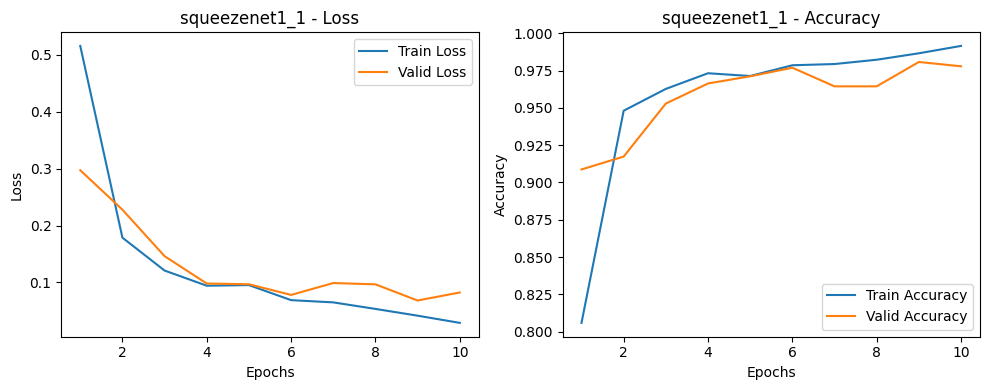


Classification Report:
               precision    recall  f1-score   support

        Mild       0.98      1.00      0.99       259
    Moderate       0.99      0.95      0.97       265
      Normal       1.00      0.99      0.99       235
      Severe       0.96      0.99      0.97       283

    accuracy                           0.98      1042
   macro avg       0.98      0.98      0.98      1042
weighted avg       0.98      0.98      0.98      1042



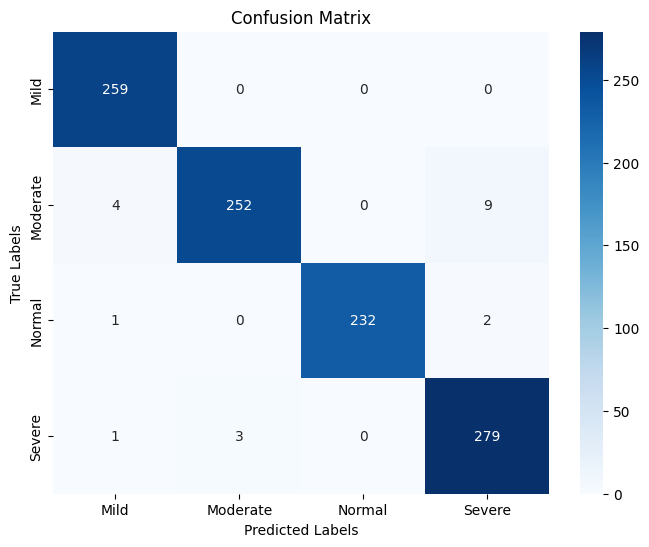

In [24]:
# SqueezeNet1_1 Model
# Load the model
model_name = "squeezenet1_1"
model = get_model(model_name)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, model_name
)

# Plot learning curves
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name)

# Evaluate on test set
evaluate_model(model, test_loader)

c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\hasri/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:08<00:00, 6.11MB/s]


Epoch [1/10]: Train Loss: 0.3207, Train Accuracy: 0.9088, Valid Loss: 0.0822, Valid Accuracy: 0.9789
Epoch [2/10]: Train Loss: 0.0614, Train Accuracy: 0.9837, Valid Loss: 0.0540, Valid Accuracy: 0.9846
Epoch [3/10]: Train Loss: 0.0251, Train Accuracy: 0.9938, Valid Loss: 0.0734, Valid Accuracy: 0.9741
Epoch [4/10]: Train Loss: 0.0143, Train Accuracy: 0.9977, Valid Loss: 0.0345, Valid Accuracy: 0.9894
Epoch [5/10]: Train Loss: 0.0156, Train Accuracy: 0.9965, Valid Loss: 0.0429, Valid Accuracy: 0.9875
Epoch [6/10]: Train Loss: 0.0093, Train Accuracy: 0.9979, Valid Loss: 0.0639, Valid Accuracy: 0.9846
Epoch [7/10]: Train Loss: 0.0114, Train Accuracy: 0.9971, Valid Loss: 0.0658, Valid Accuracy: 0.9827
Epoch [8/10]: Train Loss: 0.0079, Train Accuracy: 0.9986, Valid Loss: 0.0536, Valid Accuracy: 0.9875
Epoch [9/10]: Train Loss: 0.0143, Train Accuracy: 0.9959, Valid Loss: 0.0600, Valid Accuracy: 0.9798
Epoch [10/10]: Train Loss: 0.0067, Train Accuracy: 0.9984, Valid Loss: 0.0739, Valid Accura

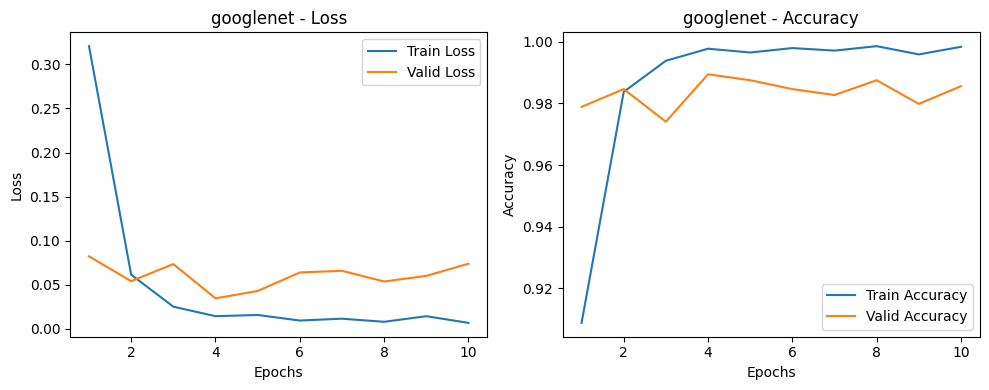


Classification Report:
               precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       259
    Moderate       0.98      0.98      0.98       265
      Normal       1.00      0.99      0.99       235
      Severe       0.97      0.98      0.98       283

    accuracy                           0.99      1042
   macro avg       0.99      0.99      0.99      1042
weighted avg       0.99      0.99      0.99      1042



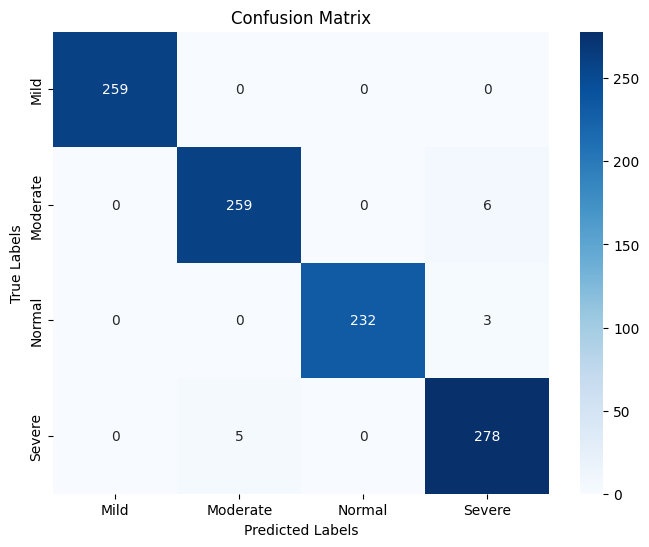

In [25]:
# GoogleNet Model
# Load the model
model_name = "googlenet"
model = get_model(model_name)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, model_name
)

# Plot learning curves
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name)

# Evaluate on test set
evaluate_model(model, test_loader)

In [26]:
# Load saved models
def load_saved_models(model_names):
    models_list = []
    for model_name in model_names:
        model = get_model(model_name)
        model_path = f"{model_save_path}/{model_name}_model.pth"
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set to evaluation mode
        models_list.append(model)
    return models_list

In [27]:
# Ensemble method
def ensemble_predict(models, inputs):
    # Collect predictions from all models
    predictions = torch.zeros((inputs.size(0), len(class_names)), device=device)
    for model in models:
        outputs = model(inputs)
        predictions += torch.softmax(outputs, dim=1)
    return torch.argmax(predictions, dim=1)

In [28]:
# Ensemble method Evaluation
def evaluate_ensemble(models, test_loader):
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            preds = ensemble_predict(models, inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification report and confusion matrix
    print("\nEnsemble Model Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)

    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Ensemble Model - Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\hasri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\mod


Ensemble Model Classification Report:
               precision    recall  f1-score   support

        Mild       0.99      1.00      0.99       259
    Moderate       0.98      0.98      0.98       265
      Normal       1.00      1.00      1.00       235
      Severe       0.99      0.98      0.98       283

    accuracy                           0.99      1042
   macro avg       0.99      0.99      0.99      1042
weighted avg       0.99      0.99      0.99      1042



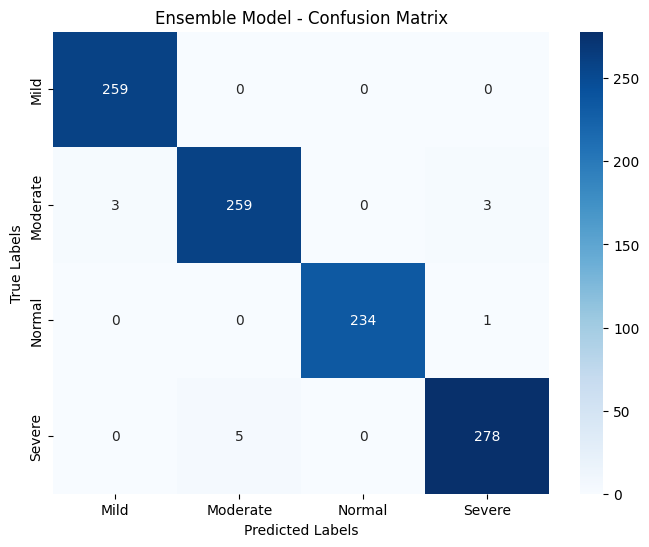

In [29]:
# Load all saved models
saved_models = load_saved_models(model_names)

# Evaluate the ensemble model
evaluate_ensemble(saved_models, test_loader)